<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 32), reused 53 (delta 11), pack-reused 0
Receiving objects: 100% (100/100), 26.18 MiB | 8.70 MiB/s, done.
Resolving deltas: 100% (32/32), done.
dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg -> dul_2021/Homework/hw1/data/geoffrey-hinton.jpg
dul_2021/Homework/hw1/data/hw1_data/mnist.pkl -> dul_2021/Homework/hw1/data/mnist.pkl
dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl -> dul_2021/Homework/hw1/data/mnist_colored.pkl
dul_2021/Homework/hw1/data/hw1_data/shapes.pkl -> dul_2021/Homework/hw1/data/shapes.pkl
dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl -> dul_2021/Homework/hw1/data/shapes_colored.pkl
dul_2021/Homework/hw1/data/hw1_data/smiley.jpg -> dul_2021/Homework/hw1/data/smiley.jpg
Processing ./dul_2021
  Preparing metadata (setup.py) ... done
  Created wheel for dul-2021: 

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam

from dul_2021.utils.hw1_utils import *
import dul_2021.utils.pytorch_utils as pytu
import torch.utils.data as data

if torch.cuda.is_available():
    pytu.set_gpu_mode(True)
else:
    pytu.set_gpu_mode(False)

In [2]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


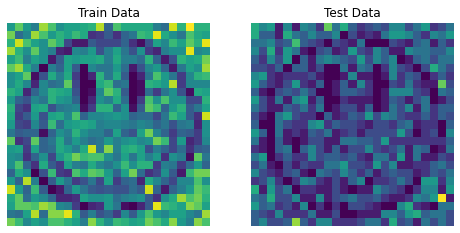

Dataset 2


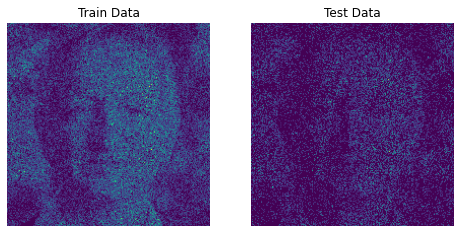

In [11]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

    def set_mask(self, mask):
        masked = torch.from_numpy(mask.astype(np.uint8))
        self.mask.data.copy_(masked)

In [ ]:
def train(model, train_data, optimizer):
    model.train()
    losses = []
    for i, x in enumerate(train_data):
        x = x.to(pytu.device).contiguous()
        loss = model.calc_loss(x)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

In [12]:
def loss_evaluation(model, dataset):
    model.eval()
    loss = 0.
    with torch.no_grad():
        for i in dataset:
            i = i.to(pytu.device).contiguous()
            loss += model.calc_loss(i) * i.shape[0]
        loss /= len(dataset.dataset)
    return loss.item()

In [ ]:
def training_epochs(model, train_dataset, test_dataset, epochs, lr):
    train_loss = []
    test_loss = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    test_lo = loss_evaluation(model, test_dataset)
    test_loss.append(test_lo)
    for epoch in tqdm(range(epochs), desc='Epochs', leave=True):
        model.train()
        train_lo = train(model, train_dataset, optimizer)
        train_loss += train_lo
        test_lo = loss_evaluation(model, test_dataset)
        test_loss.append(test_lo)  
    return train_loss, test_loss

In [14]:
class MADE(nn.Module): 
    def __init__(self, d, in_dim, hidden_s, one_hot=False):
        super().__init__()
        self.d = d
        self.m = {}
        layers = []
        self.in_dim = in_dim
        self.n_in = np.prod(self.in_dim)
        self.n_out = self.n_in * d
        self.hidden_s = hidden_s
        self.one_hot = one_hot
        sizes = [self.n_out] + [self.n_in * d if self.one_hot else self.n_in] + self.hidden_s
        for input_s, output_s in zip(sizes, sizes[1:]): # задаём сеть
            layers.append(MaskedLinear(input_s, output_s))
            layers.append(nn.ReLU())
        layers.pop() # minus relu
        self.layers = nn.Sequential(*layers) # задаём сеть
        self.set_masks()

    def set_masks(self):
        # добавляем маскирование
        self.m[- 1] = np.arange(1, self.n_in + 1)
        L = len(self.hidden_s)
        for l in range(L):
            self.m[l] = np.random.randint(np.min(self.m[l - 1]), self.n_in, size=self.hidden_s[l])
        masks = [(self.m[l][:, None] >= self.m[l - 1][None, :]) for l in range(L)]
        masks.append((self.m[- 1][:, None] >  self.m[L - 1][None, :]))
        masks[- 1] = np.repeat(masks[- 1], self.d, axis=0)
        if self.one_hot:
            masks[0] = np.repeat(masks[0], self.d, axis=1)
        layers = [l for l in self.layers.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)
    
    def forward(self, x):
        # делаем forward pass
        batch_size = x.shape[0]
        if self.one_hot is True:
            x = F.one_hot(x, num_classes=self.d).float()
        p = self.layers(x.view(batch_size, - 1).float())
        logs = p.view(batch_size, self.n_in, self.d).permute(0, 2, 1)
        res = logs.view(batch_size, self.d, *self.in_dim)
        return res

    def calc_loss(self, x):
        # вычисление лосс функции
        return F.cross_entropy(self(x), x.long())
    
    def sampling(self, num_samples):
        # функция, реализующая сэмплирование
        smpls = torch.zeros(num_samples, self.n_in, device=pytu.device)
        with torch.no_grad():
            for i in range(self.n_in):
                logs = self(smpls).view(num_samples, self.d, self.n_in, - 1)[:, :, i]
                p = F.softmax(logs, dim=1)
                s = torch.multinomial(p.squeeze(- 1), 1).squeeze(- 1)
                smpls[:, i] = s
        smpls = smpls.view((num_samples, *self.in_dim))
        smpls = smpls.detach().cpu().numpy()
        return smpls

    def dist(self): 
        # look at learnt distribution 
        point = np.mgrid[0:self.d, 0:self.d]
        point = point.reshape(2, self.d ** 2)
        point = torch.from_numpy(point.T).to(pytu.device)
        logp = F.log_softmax(self(point), dim=1)
        dist = torch.gather(logp, 1, x.unsqueeze(1)).squeeze(1)
        dist = dist.sum(dim=1).exp().view(self.d, self.d)
        dist = dist.detach().cpu().numpy()
        return dist

In [18]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    training_data = data.DataLoader(train_data, batch_size=128, shuffle=True)
    testing_data = data.DataLoader(test_data, batch_size=128)
    model = MADE(d, (2,), [1024, 1024, 1024, 1024], one_hot=True).to(pytu.device)
    train_loss, test_loss = training_epochs(model, 
                                            training_data, 
                                            testing_data, 
                                            epochs=100, 
                                            lr=1e-4)
    return train_loss, test_loss, model.dist()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results




Final Test Loss: 3.1897


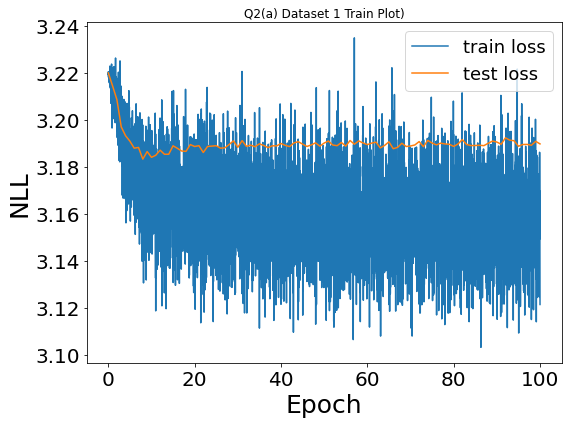

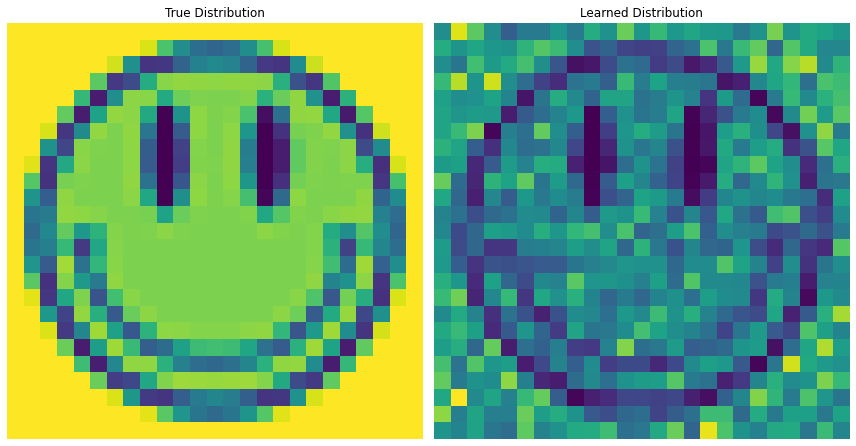

In [19]:
q1_save_results(1, 'a', q1_a)


Final Test Loss: 5.3725


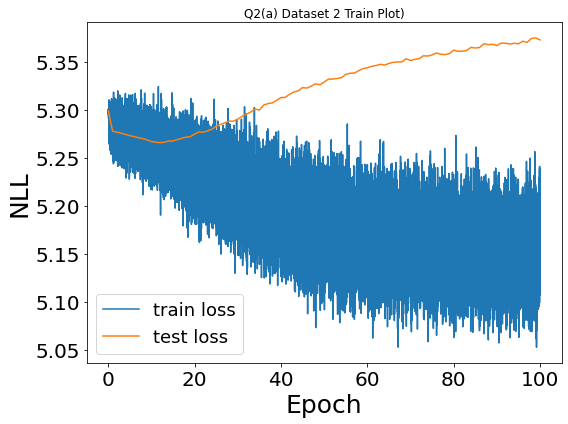

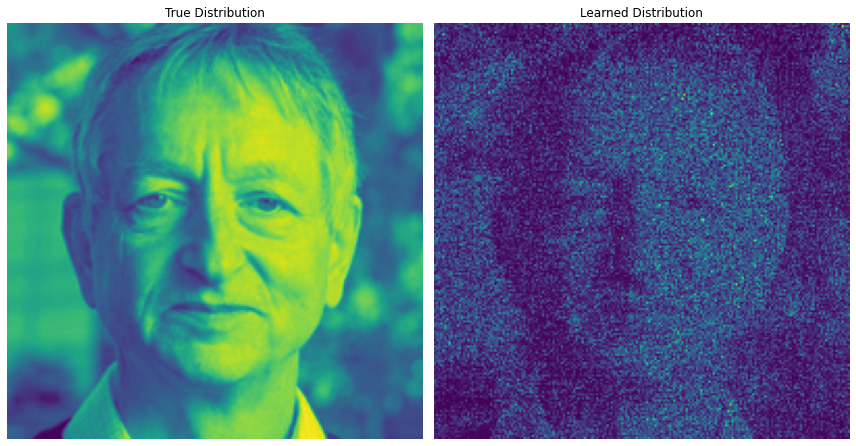

In [20]:
q1_save_results(2, 'a', q1_a) # здесь явное переобучение – нужно подбирать гиперпараметры

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

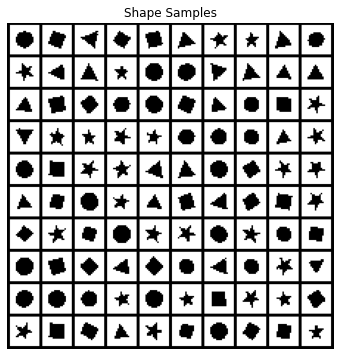

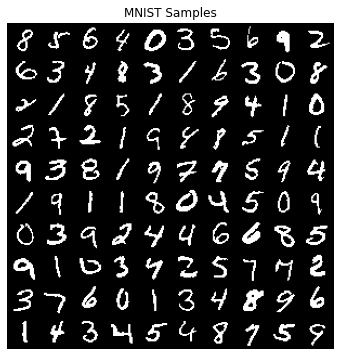

In [21]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [29]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    h, w = image_shape  
    training_data = data.DataLoader(train_data, batch_size=128, shuffle=True)
    testing_data = data.DataLoader(test_data, batch_size=128)
    model = MADE(2, (h, w, 1), [1024, 1024, 1024, 1024]).to(pytu.device)
    train_loss, test_loss = training_epochs(model, 
                                            training_data, 
                                            testing_data, 
                                            epochs=150, # 500 in the 1st & 150 in the 2nd
                                            lr=1e-5)
    return train_loss, test_loss, model.sampling(100)

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results




Final Test Loss: 0.0850


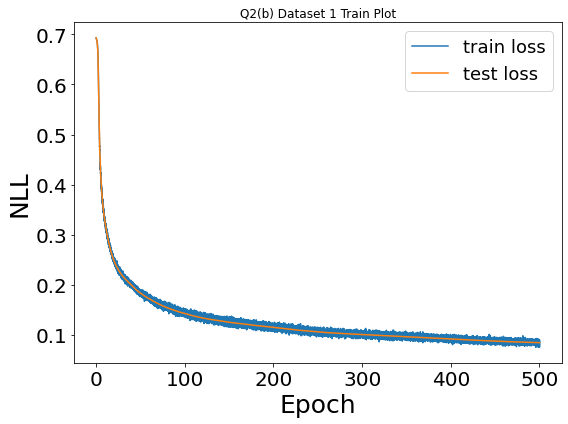

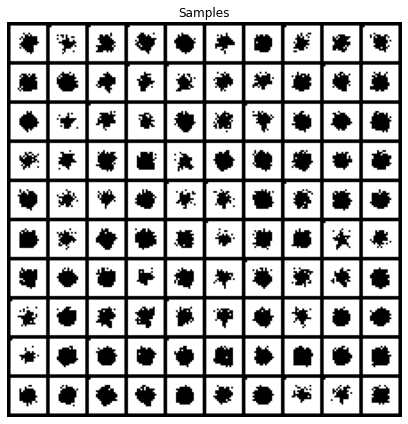

In [23]:
q1_save_results(1, 'b', q1_b) # обучение на 500 epochs
# лучше всего различима звёздочка, в целом вердикт такой: нужно продолжать тьюнить гиперпараметры + попытаться в больше эпох


Final Test Loss: 0.1790


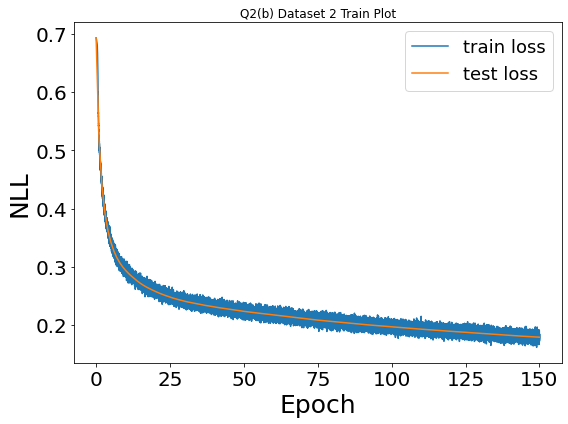

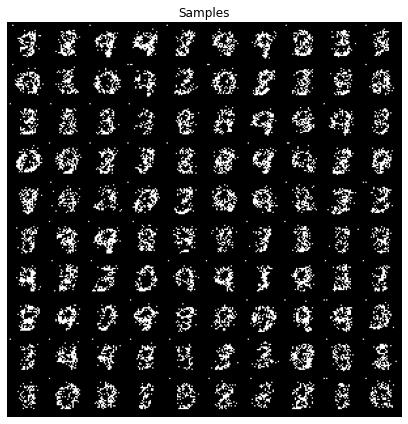

In [30]:
q1_save_results(2, 'b', q1_b) 
# только 150 epochs, потому имеем такой результат (тем не менее, цифры неплохо различимы!)
# будет лучше, если поставить больше эпох
# но на их обучение нужно больше времени